# **Data Preparation Script for Soccer Match Event Dataset**

In [4]:
# Install kaggle
!pip install -q kaggle

# Create kaggle configuration directory and place API key
!mkdir -p ~/.kaggle
!echo '{"username":"your_username","key":"your_key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d aleespinosa/soccer-match-event-dataset -p data

# Extract the dataset into the data directory
!unzip -o data/soccer-match-event-datasaet.zip -d data

# List all files inside the data directory
import os

print("Files in data directory:")
for root, dirs, files in os.walk("data"):
    for name in files:
        print(os.path.join(root, name))

Dataset URL: https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
soccer-match-event-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open data/soccer-match-event-datasaet.zip, data/soccer-match-event-datasaet.zip.zip or data/soccer-match-event-datasaet.zip.ZIP.
Files in data directory:
data/soccer-match-event-dataset.zip


# **Exploratory Data Analysis (EDA) for Soccer Match Event Dataset**

Events dataset shape: (78125, 17)
Matches dataset shape: (51, 39)

First 5 rows of events:
   eventId           subEventName                         tags  playerId  \
0        8            Simple pass               [{'id': 1801}]     26010   
1        8            Simple pass               [{'id': 1801}]      3682   
2        8            Simple pass               [{'id': 1801}]     31528   
3        8              High pass               [{'id': 1802}]      7855   
4        1  Ground defending duel  [{'id': 702}, {'id': 1801}]     25437   

                                  positions  matchId eventName  teamId  \
0  [{'y': 48, 'x': 50}, {'y': 50, 'x': 47}]  1694390      Pass    4418   
1  [{'y': 50, 'x': 47}, {'y': 48, 'x': 41}]  1694390      Pass    4418   
2  [{'y': 48, 'x': 41}, {'y': 35, 'x': 32}]  1694390      Pass    4418   
3   [{'y': 35, 'x': 32}, {'y': 6, 'x': 89}]  1694390      Pass    4418   
4    [{'y': 6, 'x': 89}, {'y': 0, 'x': 85}]  1694390      Duel    4418   

  match

/tmp/ipython-input-2702984501.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=matches, x='match_outcome', palette="Set2")


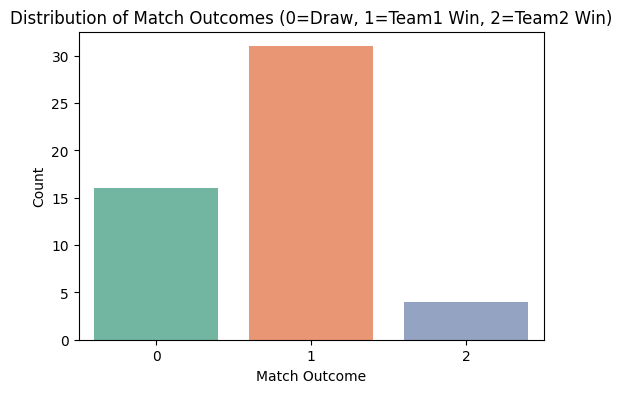

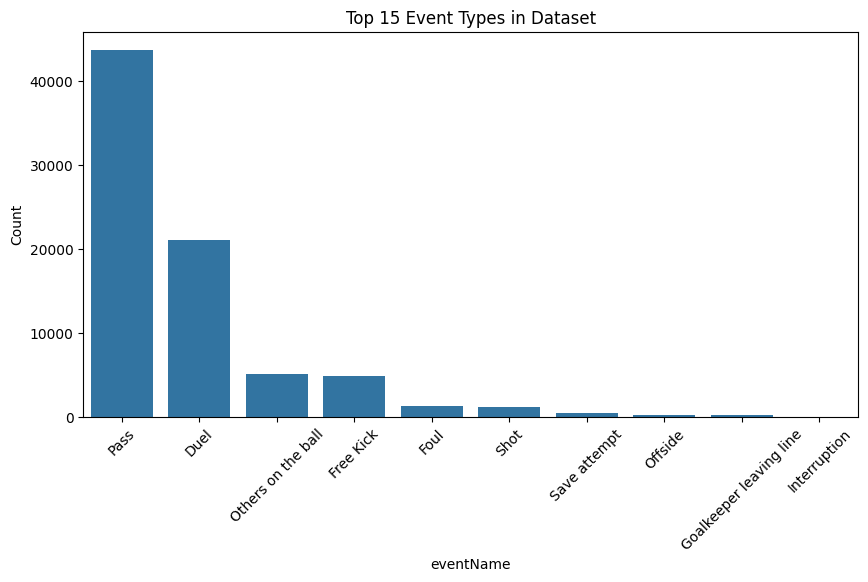

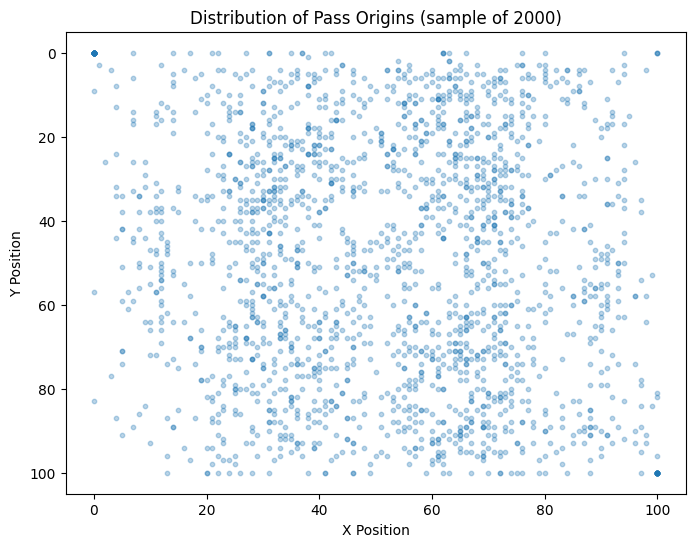


Basic statistics of numerical columns in events:
            eventId       playerId       matchId        teamId      eventSec  \
count  78125.000000   78125.000000  7.812500e+04  78125.000000  78125.000000   
mean       5.656038   45330.458688  1.694415e+06   8021.241549   1351.039153   
std        3.174001   54201.421803  1.495746e+01   3920.231494    829.807973   
min        1.000000      36.000000  1.694390e+06   1598.000000      0.011646   
25%        1.000000    8372.000000  1.694403e+06   4418.000000    617.838402   
50%        8.000000   21097.000000  1.694416e+06   8274.000000   1322.482340   
75%        8.000000   70134.000000  1.694428e+06  10682.000000   2063.232415   
max       10.000000  397178.000000  1.694440e+06  14622.000000   3272.106197   

         subEventId            id    pos_orig_y    pos_orig_x    pos_dest_y  \
count  77937.000000  7.812500e+04  78125.000000  78125.000000  78125.000000   
mean      59.756970  8.893912e+07     49.370637     51.588749     49.29

In [6]:
# -----------------------------
# 1. Dataset Exploration (EDA)
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load datasets ---
events = pd.read_csv("data/events_European_Championship.csv")
matches = pd.read_csv("data/matches_European_Championship.csv")

print("Events dataset shape:", events.shape)
print("Matches dataset shape:", matches.shape)

print("\nFirst 5 rows of events:")
print(events.head())

print("\nFirst 5 rows of matches:")
print(matches.head())

print("\nMissing values in events:")
print(events.isnull().sum())

# --- Merge to get match outcomes ---
matches['match_outcome'] = matches.apply(
    lambda row: 1 if row['team1.score'] > row['team2.score']
    else (2 if row['team1.score'] < row['team2.score'] else 0), axis=1
)

# Merge into events
events = events.merge(matches[['wyId', 'match_outcome']],
                      left_on='matchId', right_on='wyId', how='left')

# --- Distribution of match outcomes ---
plt.figure(figsize=(6,4))
sns.countplot(data=matches, x='match_outcome', palette="Set2")
plt.title("Distribution of Match Outcomes (0=Draw, 1=Team1 Win, 2=Team2 Win)")
plt.xlabel("Match Outcome")
plt.ylabel("Count")
plt.show()

# --- Distribution of event types ---
plt.figure(figsize=(10,5))
sns.countplot(data=events, x='eventName', order=events['eventName'].value_counts().index[:15])
plt.xticks(rotation=45)
plt.title("Top 15 Event Types in Dataset")
plt.ylabel("Count")
plt.show()

# --- Scatter plot for pass origins ---
if 'pos_orig_x' in events.columns and 'pos_orig_y' in events.columns:
    plt.figure(figsize=(8,6))
    sample_passes = events[events['eventName']=="Pass"].sample(2000, random_state=42)
    plt.scatter(sample_passes['pos_orig_x'], sample_passes['pos_orig_y'], alpha=0.3, s=10)
    plt.title("Distribution of Pass Origins (sample of 2000)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.gca().invert_yaxis()  # football field style
    plt.show()

# --- Basic statistics ---
print("\nBasic statistics of numerical columns in events:")
print(events.describe())


# **SoccerMatchEnv - Reinforcement Learning Environment**

In [ ]:
# -----------------------------
# 3. Define Gym environment
# -----------------------------
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import random

class SoccerMatchEnv(gym.Env):
    def __init__(self, df):
        # Initialize the environment with the dataframe
        super(SoccerMatchEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.match_ids = df['matchId'].unique()
        self.current_match = None
        self.current_idx = 0

        # Observation: positions (4 values)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float32)
        # Action: predict outcome {0=draw, 1=team1 win, 2=team2 win}
        self.action_space = spaces.Discrete(3)

    def reset(self):
        # Randomly select a match and reset index
        self.current_match = random.choice(self.match_ids)
        self.match_events = self.df[self.df['matchId'] == self.current_match].reset_index(drop=True)
        self.current_idx = 0
        return self._get_obs()

    def _get_obs(self):
        # Get current observation based on feature columns
        row = self.match_events.loc[self.current_idx, ['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']]
        return np.array(row, dtype=np.float32)

    def step(self, action):
        # Reward: +1 if prediction matches actual outcome
        actual = self.match_events.loc[self.current_idx, 'match_outcome']
        reward = 1.0 if action == actual else -1.0

        # Move to next event or end of match
        self.current_idx += 1
        done = self.current_idx >= len(self.match_events)
        obs = self._get_obs() if not done else np.zeros(4, dtype=np.float32)
        return obs, reward, done, False, {}

# **Test1**

# Deep Q-Learning Implementation for Soccer Match Outcome Prediction

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-1534197422.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(self.device)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return da

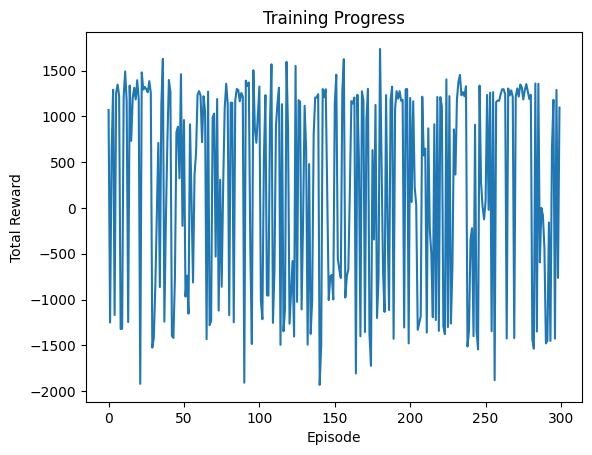

In [7]:
# -----------------------------
# 0. Library imports
# -----------------------------
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# 1. Load data and merge match outcomes
# -----------------------------
events = pd.read_csv("data/events_European_Championship.csv")
matches = pd.read_csv("data/matches_European_Championship.csv")

# Merge outcome based on matchId
events = events.merge(matches[['wyId','team1.score','team2.score']],
                      left_on='matchId', right_on='wyId', how='left')

# Define simple match outcome: 0=draw, 1=team1 win, 2=team2 win
def outcome(row):
    if row['team1.score'] > row['team2.score']:
        return 1
    elif row['team1.score'] < row['team2.score']:
        return 2
    else:
        return 0

events['match_outcome'] = events.apply(outcome, axis=1)

# -----------------------------
# 2. Prepare features for RL environment
# -----------------------------
# Simplify features: origin and destination positions normalized
events['pos_orig_x'] = events['pos_orig_x'] / 100.0
events['pos_orig_y'] = events['pos_orig_y'] / 100.0
events['pos_dest_x'] = events['pos_dest_x'] / 100.0
events['pos_dest_y'] = events['pos_dest_y'] / 100.0

feature_cols = ['pos_orig_x','pos_orig_y','pos_dest_x','pos_dest_y']
target_col = 'match_outcome'

# -----------------------------
# 3. Define Gym environment
# -----------------------------
class SoccerMatchEnv(gym.Env):
    def __init__(self, df):
        super(SoccerMatchEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.match_ids = df['matchId'].unique()
        self.current_match = None
        self.current_idx = 0

        # Observation: positions (4 values)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float32)
        # Action: predict outcome {0=draw, 1=team1 win, 2=team2 win}
        self.action_space = spaces.Discrete(3)

    def reset(self):
        self.current_match = random.choice(self.match_ids)
        self.match_events = self.df[self.df['matchId']==self.current_match].reset_index(drop=True)
        self.current_idx = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.match_events.loc[self.current_idx, feature_cols]
        return np.array(row, dtype=np.float32)

    def step(self, action):
        # Reward: +1 if prediction matches actual outcome
        actual = self.match_events.loc[self.current_idx, target_col]
        reward = 1.0 if action == actual else -1.0

        # Move to next event or end of match
        self.current_idx += 1
        done = self.current_idx >= len(self.match_events)
        obs = self._get_obs() if not done else np.zeros(len(feature_cols), dtype=np.float32)
        return obs, reward, done, False, {}

# -----------------------------
# 4. Define DQN network
# -----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# -----------------------------
# 5. DQN Agent
# -----------------------------
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1, batch_size=64, memory_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim-1)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * next_q * (1 - dones)
        loss = self.loss_fn(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# -----------------------------
# 6. Training loop
# -----------------------------
env = SoccerMatchEnv(events)
agent = DQNAgent(state_dim=4, action_dim=3)

episodes = 300
target_update = 10
all_rewards = []

for ep in tqdm(range(episodes)):
    state = env.reset()
    ep_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        ep_reward += reward
    all_rewards.append(ep_reward)
    if ep % target_update == 0:
        agent.update_target()

# -----------------------------
# 7. Plot rewards
# -----------------------------
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()


# **Training Results Management and Visualization**

Results saved to training_results.csv

Summary of training results:
          episode  total_reward
count  300.000000    300.000000
mean   150.500000    247.973333
std     86.746758   1126.012252
min      1.000000  -1933.000000
25%     75.750000   -983.500000
50%    150.500000    843.000000
75%    225.250000   1233.000000
max    300.000000   1738.000000

First 10 episodes:
   episode  total_reward
0        1        1071.0
1        2       -1252.0
2        3         604.0
3        4        1292.0
4        5       -1170.0
5        6        1258.0
6        7        1348.0
7        8        1226.0
8        9       -1323.0
9       10       -1319.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


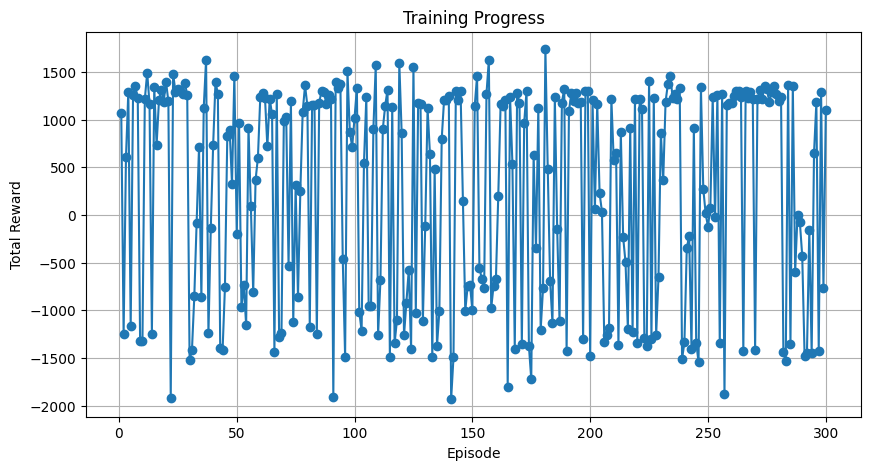

In [10]:
# -----------------------------
# 8. Save and print training results
# -----------------------------
import pandas as pd

# ساخت DataFrame
results_df = pd.DataFrame({
    "episode": list(range(1, episodes+1)),
    "total_reward": all_rewards
})

# ذخیره به CSV
results_df.to_csv("training_results.csv", index=False)
print("Results saved to training_results.csv")

# پرینت خلاصه و چند ردیف اول
print("\nSummary of training results:")
print(results_df.describe())

print("\nFirst 10 episodes:")
print(results_df.head(10))

# نمودار خطی روند آموزش
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(results_df['episode'], results_df['total_reward'], marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.grid(True)
plt.show()


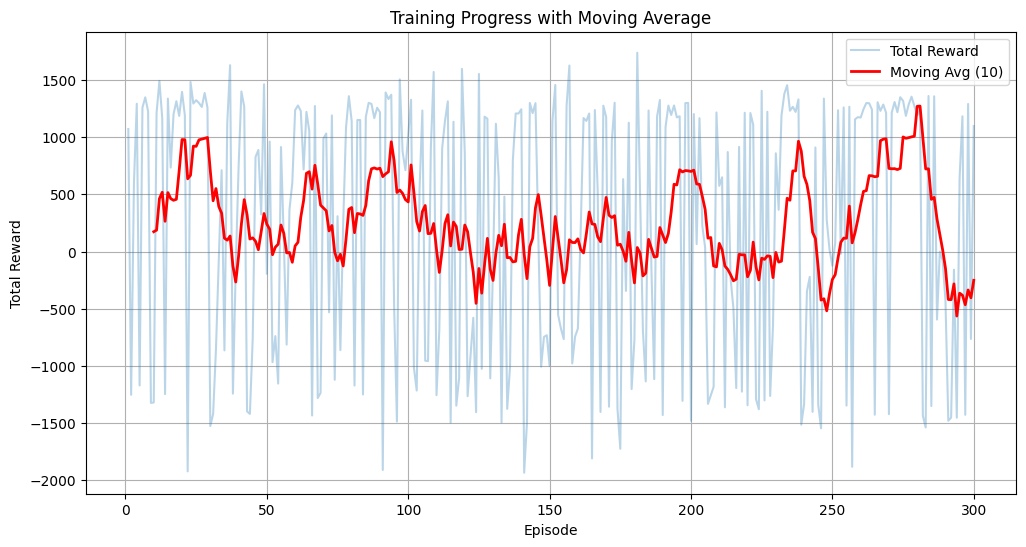

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# اگر نتایج قبلاً ذخیره شده:
results = pd.read_csv("training_results.csv")

# محاسبه میانگین متحرک (moving average) با پنجره 10 اپیزود
window = 10
results['moving_avg'] = results['total_reward'].rolling(window=window).mean()

# رسم نمودار
plt.figure(figsize=(12,6))
plt.plot(results['episode'], results['total_reward'], alpha=0.3, label="Total Reward")
plt.plot(results['episode'], results['moving_avg'], color='red', linewidth=2, label=f"Moving Avg ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress with Moving Average")
plt.legend()
plt.grid(True)
plt.show()


# **Test2**

In [12]:
# ==============================
# 0. Library imports
# ==============================
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# ==============================
# 1. Load data
# ==============================
events = pd.read_csv("data/events_European_Championship.csv")
matches = pd.read_csv("data/matches_European_Championship.csv")

# Merge match outcome
events = events.merge(matches[['wyId','team1.score','team2.score']],
                      left_on='matchId', right_on='wyId', how='left')

def outcome(row):
    if row['team1.score'] > row['team2.score']:
        return 1
    elif row['team1.score'] < row['team2.score']:
        return 2
    else:
        return 0
events['match_outcome'] = events.apply(outcome, axis=1)

# Normalize positions
events['pos_orig_x'] /= 100.0
events['pos_orig_y'] /= 100.0
events['pos_dest_x'] /= 100.0
events['pos_dest_y'] /= 100.0

feature_cols = ['pos_orig_x','pos_orig_y','pos_dest_x','pos_dest_y']
target_col = 'match_outcome'

# ==============================
# 2. Define SoccerMatchEnv
# ==============================
class SoccerMatchEnv(gym.Env):
    def __init__(self, df):
        super(SoccerMatchEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.match_ids = df['matchId'].unique()
        self.current_match = None
        self.current_idx = 0

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_match = random.choice(self.match_ids)
        self.match_events = self.df[self.df['matchId']==self.current_match].reset_index(drop=True)
        self.current_idx = 0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.match_events.loc[self.current_idx, feature_cols]
        return np.array(row, dtype=np.float32)

    def step(self, action):
        actual = self.match_events.loc[self.current_idx, target_col]
        reward = 1.0 if action == actual else -1.0
        self.current_idx += 1
        done = self.current_idx >= len(self.match_events)
        obs = self._get_obs() if not done else np.zeros(len(feature_cols), dtype=np.float32)
        return obs, reward, done, False, {}

# ==============================
# 3. Q-Network (bigger layers)
# ==============================
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# ==============================
# 4. DQN Agent with Soft Update
# ==============================
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-4, batch_size=128, buffer_size=100000, tau=0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.tau = tau

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.loss_fn = nn.SmoothL1Loss()

        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.tensor(np.array([state], dtype=np.float32), device=self.device)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states, dtype=np.float32), device=self.device)
        actions = torch.tensor(np.array(actions, dtype=np.int64), device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards, dtype=np.float32), device=self.device)
        next_states = torch.tensor(np.array(next_states, dtype=np.float32), device=self.device)
        dones = torch.tensor(np.array(dones, dtype=np.bool_), device=self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            expected_q_values = rewards + self.gamma * next_q_values * (~dones)

        loss = self.loss_fn(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update_target_net()
        return loss.item()

    def soft_update_target_net(self):
        target_state = self.target_net.state_dict()
        policy_state = self.policy_net.state_dict()
        for key in policy_state:
            target_state[key] = policy_state[key]*self.tau + target_state[key]*(1-self.tau)
        self.target_net.load_state_dict(target_state)

# ==============================
# 5. Training Loop
# ==============================
env = SoccerMatchEnv(events)
agent = DQNAgent(state_dim=4, action_dim=3)
episodes = 600

epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 1000
steps_done = 0

results = []
rewards_deque = deque(maxlen=100)

for episode in tqdm(range(1, episodes+1)):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay)
        steps_done += 1
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward

    results.append((episode, total_reward))
    rewards_deque.append(total_reward)
    avg_reward = np.mean(rewards_deque)

    if (episode % 25 == 0):
        print(f"\nEpisode {episode}/{episodes} | Reward: {total_reward:.2f} | Avg(100): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

df = pd.DataFrame(results, columns=["episode","total_reward"])
df.to_csv("training_results_soccer.csv", index=False)
print("Final results saved to training_results_soccer.csv")

plt.plot(df["episode"], df["total_reward"], label="Reward", alpha=0.6)
plt.plot(df["episode"], df["total_reward"].rolling(20).mean(), label="Moving Avg(20)", color="red", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Progress on SoccerMatchEnv")
plt.legend()
plt.show()


Using device: cpu


  4%|▍         | 27/600 [00:02<00:51, 11.03it/s]


Episode 25/600 | Total Reward: 12.00 | Avg Reward (last 100): 18.36 | Epsilon: 0.636


  8%|▊         | 50/600 [00:04<00:54, 10.01it/s]


Episode 50/600 | Total Reward: 15.00 | Avg Reward (last 100): 16.44 | Epsilon: 0.446


 12%|█▎        | 75/600 [00:28<15:11,  1.74s/it]


Episode 75/600 | Total Reward: 227.00 | Avg Reward (last 100): 52.12 | Epsilon: 0.030


 17%|█▋        | 100/600 [01:05<11:16,  1.35s/it]


Episode 100/600 | Total Reward: 199.00 | Avg Reward (last 100): 88.00 | Epsilon: 0.010


 21%|██        | 125/600 [01:46<13:51,  1.75s/it]


Episode 125/600 | Total Reward: 206.00 | Avg Reward (last 100): 134.95 | Epsilon: 0.010


 25%|██▌       | 150/600 [02:33<14:07,  1.88s/it]


Episode 150/600 | Total Reward: 246.00 | Avg Reward (last 100): 192.00 | Epsilon: 0.010


 29%|██▉       | 175/600 [03:17<13:39,  1.93s/it]


Episode 175/600 | Total Reward: 218.00 | Avg Reward (last 100): 217.02 | Epsilon: 0.010


 33%|███▎      | 200/600 [04:06<15:52,  2.38s/it]


Episode 200/600 | Total Reward: 291.00 | Avg Reward (last 100): 232.39 | Epsilon: 0.010


 38%|███▊      | 225/600 [04:54<09:34,  1.53s/it]


Episode 225/600 | Total Reward: 204.00 | Avg Reward (last 100): 240.81 | Epsilon: 0.010


 42%|████▏     | 250/600 [05:55<19:13,  3.29s/it]


Episode 250/600 | Total Reward: 419.00 | Avg Reward (last 100): 258.12 | Epsilon: 0.010


 46%|████▌     | 275/600 [07:25<20:39,  3.81s/it]


Episode 275/600 | Total Reward: 500.00 | Avg Reward (last 100): 315.27 | Epsilon: 0.010


 50%|█████     | 300/600 [09:06<19:46,  3.96s/it]


Episode 300/600 | Total Reward: 500.00 | Avg Reward (last 100): 375.99 | Epsilon: 0.010


 54%|█████▍    | 325/600 [10:48<19:18,  4.21s/it]


Episode 325/600 | Total Reward: 500.00 | Avg Reward (last 100): 441.03 | Epsilon: 0.010


 56%|█████▌    | 336/600 [11:37<09:08,  2.08s/it]


Environment solved in 337 episodes!
Final results saved to training_results_final.csv


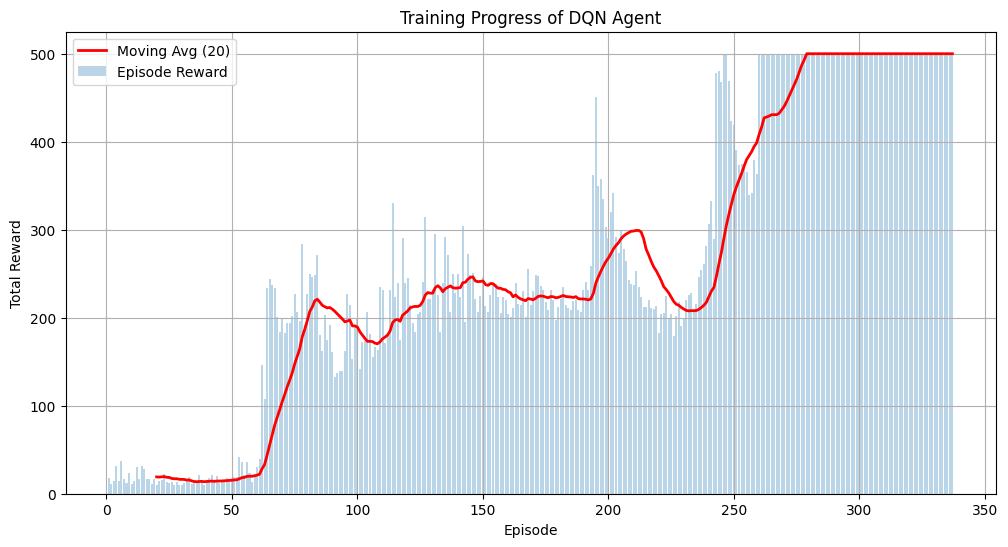

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(df["episode"], df["total_reward"], alpha=0.3, label="Episode Reward")
plt.plot(df["episode"], df["total_reward"].rolling(20).mean(), label="Moving Avg (20)", linewidth=2, color="red")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN Agent")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ==============================
# 0. Library imports
# ==============================
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# ==============================
# 1. Load data
# ==============================
events = pd.read_csv("data/events_European_Championship.csv")
matches = pd.read_csv("data/matches_European_Championship.csv")

# Merge match outcome
events = events.merge(matches[['wyId','team1.score','team2.score']],
                      left_on='matchId', right_on='wyId', how='left')

def outcome(row):
    if row['team1.score'] > row['team2.score']:
        return 1
    elif row['team1.score'] < row['team2.score']:
        return 2
    else:
        return 0
events['match_outcome'] = events.apply(outcome, axis=1)

# Normalize positions
events['pos_orig_x'] /= 100.0
events['pos_orig_y'] /= 100.0
events['pos_dest_x'] /= 100.0
events['pos_dest_y'] /= 100.0

feature_cols = ['pos_orig_x','pos_orig_y','pos_dest_x','pos_dest_y']
target_col = 'match_outcome'

# ==============================
# 2. Define SoccerMatchEnv
# ==============================
class SoccerMatchEnv(gym.Env):
    def __init__(self, df):
        super(SoccerMatchEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.match_ids = df['matchId'].unique()
        self.current_match = None
        self.current_idx = 0

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_match = random.choice(self.match_ids)
        self.match_events = self.df[self.df['matchId']==self.current_match].reset_index(drop=True)
        self.current_idx = 0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.match_events.loc[self.current_idx, feature_cols]
        return np.array(row, dtype=np.float32)

    def step(self, action):
        actual = self.match_events.loc[self.current_idx, target_col]
        reward = 1.0 if action == actual else -1.0
        self.current_idx += 1
        done = self.current_idx >= len(self.match_events)
        obs = self._get_obs() if not done else np.zeros(len(feature_cols), dtype=np.float32)
        return obs, reward, done, False, {}

# ==============================
# 3. Q-Network (bigger layers)
# ==============================
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# ==============================
# 4. DQN Agent with Soft Update
# ==============================
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-4, batch_size=128, buffer_size=100000, tau=0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.tau = tau

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.loss_fn = nn.SmoothL1Loss()

        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.tensor(np.array([state], dtype=np.float32), device=self.device)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states, dtype=np.float32), device=self.device)
        actions = torch.tensor(np.array(actions, dtype=np.int64), device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards, dtype=np.float32), device=self.device)
        next_states = torch.tensor(np.array(next_states, dtype=np.float32), device=self.device)
        dones = torch.tensor(np.array(dones, dtype=np.bool_), device=self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            expected_q_values = rewards + self.gamma * next_q_values * (~dones)

        loss = self.loss_fn(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update_target_net()
        return loss.item()

    def soft_update_target_net(self):
        target_state = self.target_net.state_dict()
        policy_state = self.policy_net.state_dict()
        for key in policy_state:
            target_state[key] = policy_state[key]*self.tau + target_state[key]*(1-self.tau)
        self.target_net.load_state_dict(target_state)

# ==============================
# 5. Training Loop
# ==============================
env = SoccerMatchEnv(events)
agent = DQNAgent(state_dim=4, action_dim=3)
episodes = 600

epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 1000
steps_done = 0

results = []
rewards_deque = deque(maxlen=100)

for episode in tqdm(range(1, episodes+1)):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay)
        steps_done += 1
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward

    results.append((episode, total_reward))
    rewards_deque.append(total_reward)
    avg_reward = np.mean(rewards_deque)

    if (episode % 25 == 0):
        print(f"\nEpisode {episode}/{episodes} | Reward: {total_reward:.2f} | Avg(100): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

df = pd.DataFrame(results, columns=["episode","total_reward"])
df.to_csv("training_results_soccer.csv", index=False)
print("Final results saved to training_results_soccer.csv")

plt.plot(df["episode"], df["total_reward"], label="Reward", alpha=0.6)
plt.plot(df["episode"], df["total_reward"].rolling(20).mean(), label="Moving Avg(20)", color="red", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Progress on SoccerMatchEnv")
plt.legend()
plt.show()
